<a href="https://colab.research.google.com/github/junhill-2000/PlayWithMuJoCo/blob/main/PlayWithContinuousControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻 **WELCOME TO "PLAY WITH CONTINUOUS CONTROL" TUTORIAL** 🤖

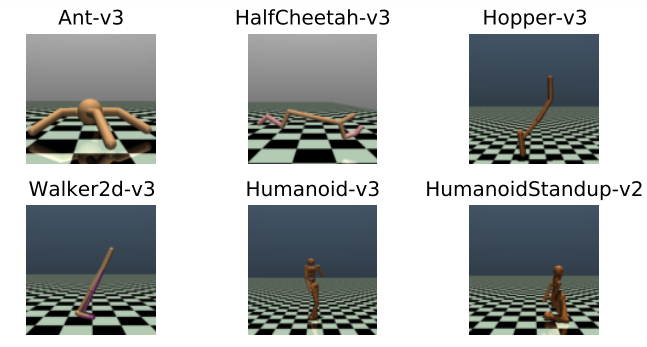

In this **tutorial**, you will learn to use Machine Learning Tools to control physical bodies 🤖 in simulation (the ones above 👆👆👆) via Model-Free Reinforcement Learning (Meaning there is no need to be fluent in Robotics)

There will be n steps in this tutorial:      
 

1.   Installing necessary packages 📦 in Google Colab (Deepmind's MuJoCo simulator, OpenAI's Gym, Tianshou)
2.   Learn to initiate a policy network (aka. our controller 🎮)
3.   Learn to train your policy network (with actor-critic architecture, using Tianshou RL library 🧰)
4.   Watch your **well-trained** agents walk and make a small video 📽.

😊 Let's get started 😊

In [ ]:
# @title Install Mujoco Simulator on Colab 
%%capture
!gdown --id 1H6PkDQGlp5bUfvanbYPv-Of9ZZ8OSDHJ
!chmod +x mujoco_colab.sh 
!./mujoco_colab.sh

In [ ]:
# @title Install Gym and mujoco_py
%%capture
import os
os.environ['LD_LIBRARY_PATH'] += ':'
os.environ['LD_LIBRARY_PATH'] += '/root/.mujoco/mujoco200/bin'
os.environ.get("LD_LIBRARY_PATH", "")

!pip3 install gym==0.19.0 mujoco-py==2.0.2.13 tianshou

In [ ]:
# @title Import
from typing import Callable, Dict, Optional, Union, List, Any
from collections import defaultdict
import argparse
import datetime
import warnings
import time
import tqdm
import os

import gym
from gym import logger
from gym.wrappers.monitoring import video_recorder

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.trainer import offpolicy_trainer, gather_info, test_episode
from tianshou.env import BaseVectorEnv, DummyVectorEnv
from tianshou.policy import BasePolicy, SACPolicy
from tianshou.utils.net.continuous import ActorProb, Critic
from tianshou.utils.net.common import Net

from tianshou.data.batch import _alloc_by_keys_diff
from tianshou.data import Batch, Collector, ReplayBuffer, ReplayBufferManager, VectorReplayBuffer, CachedReplayBuffer, to_numpy
from tianshou.env import SubprocVectorEnv, BaseVectorEnv, DummyVectorEnv
from tianshou.utils import TensorboardLogger, BaseLogger, LazyLogger, MovAvg, tqdm_config

In [ ]:
# @title utility functions
def nullable_string(val):
    if not val:
        return None
    return val

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)

def save_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, 'policy.pth'))

In [ ]:
# @title Hyper-parameters for training
parser = argparse.ArgumentParser()
parser.add_argument('--foo', type=nullable_string)
args = parser.parse_args(['--foo', ''])

args.task = 'Hopper-v3' # @param {type:"string"}
args.logdir = 'log' # @param {type: "string"}
args.resume_path = None # @param {type: "string"}
args.seed = 1 # @param {type: "integer"}
args.buffer_size = 999996 # @param {type:"integer"}
args.hidden_sizes = [256, 256] # @param
args.actor_lr = 1e-3 # @param {type:"number"}
args.critic_lr = 1e-3 # @param {type: "number"}
args.gamma = 0.99 # @param {type: "number"}
args.tau = 0.005 # @param {type: "number"}
args.alpha = 0.2 # @param {type: "number"}
args.alpha_lr = 3e-4 # @param {type: "number"}
args.start_timesteps = 1000 # @param {type: "integer"}
args.epoch = 200 # @param {type: "integer"}
args.step_per_epoch = 5000 # @param {type: "integer"}
args.step_per_collect = 1 # @param {type: "integer"}
args.update_per_step = 1 # @param {type: "number"}
args.n_step = 1 # @param {type: "integer"}
args.batch_size = 128 # @param {type: "integer"}
args.test_num =  5# @param {type: "integer"}
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# @title What are those gym environment?
env = gym.make(args.task)
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]
print("Tasks: ", args.task)
print("Observations shape:", args.state_shape)
print("Actions shape:", args.action_shape)
print("Max action:", args.max_action)
print("Min action:", env.action_space.low[0])

Tasks:  Hopper-v3
Observations shape: (11,)
Actions shape: (3,)
Max action: 1.0
Min action: -1.0


# How to train your Controller 🎮 (with Tianshou)

> Reference: https://github.com/thu-ml/tianshou/blob/master/examples/mujoco/mujoco_sac.py

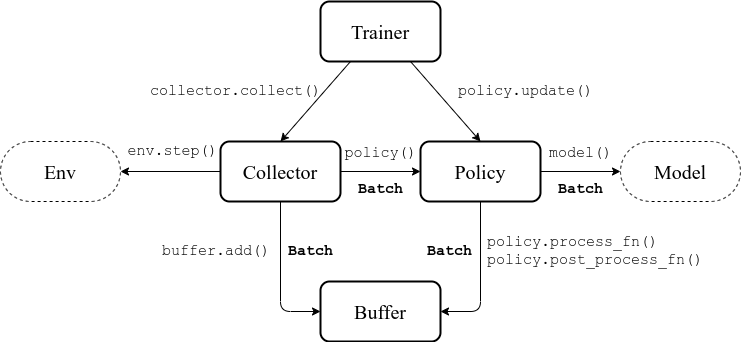

# Function create_policy
What it does: create policy neural network according to problem dimension

Usage: create_policy(environment name)

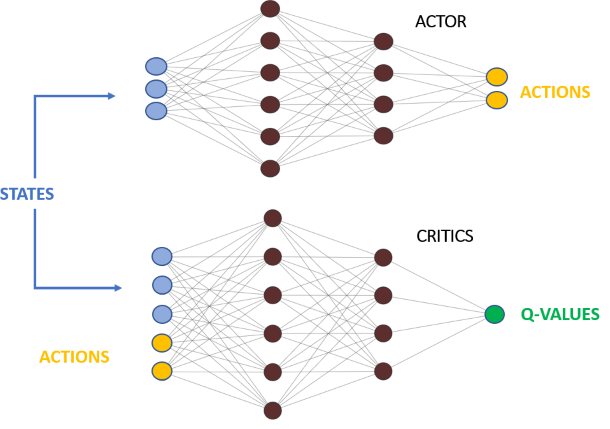

In [ ]:
# @title create_policy function
def create_policy(env_name, hidden_sizes=[256, 256], device='cpu', actor_lr=3e-4, critic_lr=3e-4, tau=0.005, alpha=0.2, gamma=0.99, n_step=1):
    env = gym.make(env_name)
    # Dimension of a task
    state_shape = env.observation_space.shape or env.observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    max_action = env.action_space.high[0]

    # a Multi-layer Perceptron.
    net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
    # Define Actor/Controller
    actor = ActorProb(net_a, action_shape, max_action=max_action, device=device,
                    unbounded=True, conditioned_sigma=True).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)
    # Define MLP for critics
    net_c1 = Net(state_shape, action_shape, hidden_sizes=hidden_sizes,
                concat=True, device=device)
    net_c2 = Net(state_shape, action_shape, hidden_sizes=hidden_sizes,
                concat=True, device=device)
    critic1 = Critic(net_c1, device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
    critic2 = Critic(net_c2, device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

    return SACPolicy(actor, actor_optim, critic1, critic1_optim, critic2, critic2_optim, tau=tau,
            gamma=gamma, alpha=alpha, estimation_step=n_step, action_space=env.action_space)

In [ ]:
# @title create environment and policy 
train_envs = gym.make(args.task)
test_envs = SubprocVectorEnv(
        [lambda: gym.make(args.task) for _ in range(args.test_num)]
    )
seed_everything(args.seed)

policy = create_policy(args.task, args.hidden_sizes, 
                    args.device, args.actor_lr, args.critic_lr, 
                    args.tau, args.alpha, args.gamma, args.n_step)

In [ ]:
# @title create data buffer, data collector for train and test
buffer = ReplayBuffer(args.buffer_size)
train_collector = Collector(policy, train_envs, buffer, exploration_noise=True)
test_collector = Collector(policy, test_envs)
train_collector.collect(n_step=args.start_timesteps, random=True)

/usr/local/lib/python3.7/dist-packages/tianshou/data/collector.py:61: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


{'idxs': array([  0,  14,  32,  48,  59,  96, 119, 133, 157, 184, 208, 227, 257,
        272, 319, 343, 353, 365, 396, 442, 514, 537, 553, 594, 614, 625,
        661, 686, 721, 738, 749, 772, 787, 826, 865, 888, 916, 930, 953]),
 'len': 24.76923076923077,
 'len_std': 12.676369168879546,
 'lens': array([14, 18, 16, 11, 37, 23, 14, 24, 27, 24, 19, 30, 15, 47, 24, 10, 12,
        31, 46, 72, 23, 16, 41, 20, 11, 36, 25, 35, 17, 11, 23, 15, 39, 39,
        23, 28, 14, 23, 13]),
 'n/ep': 39,
 'n/st': 1000,
 'rew': 20.92655285009876,
 'rew_std': 15.31624271311818,
 'rews': array([ 9.68150051, 10.18877806, 16.06820247,  9.50630663, 52.01693646,
        27.53889077,  7.91500728, 11.98201112, 12.9609323 , 28.5203808 ,
         8.63845588, 12.86366544,  9.3794557 , 46.52240027, 10.39247983,
         7.36130406,  9.82740586, 34.62691978, 45.92533517, 58.7727257 ,
        18.20676823,  8.54983235, 63.99615826, 16.85341024,  8.59771841,
        48.07588225, 16.54213765, 23.25933053, 14.42106231,  7.

In [ ]:
# @title logging for tensorboard
t0 = datetime.datetime.now().strftime("%m%d_%H%M%S")
log_file = f'seed_{args.seed}_{t0}-{args.task.replace("-", "_")}_sac'
log_path = os.path.join(args.logdir, args.task, 'sac', log_file)
writer = SummaryWriter(log_path)
writer.add_text("args", str(args))
logger = TensorboardLogger(writer)

In [ ]:
# @title stuffs to do before training
start_epoch, env_step, gradient_step = 0, 0, 0
last_rew, last_len = 0.0, 0
stat: Dict[str, MovAvg] = defaultdict(MovAvg)
start_time = time.time()
train_collector.reset_stat()

episode_per_test=10
test_fn=None

test_c: Collector = test_collector  # for mypy
test_collector.reset_stat()
test_result = test_episode(
    policy, test_c, test_fn, start_epoch, episode_per_test, logger, env_step
)
best_epoch = start_epoch
best_reward, best_reward_std = test_result["rew"], test_result["rew_std"]

save_fn(policy)

In [ ]:
# @title Training SAC agent (off policy trainer)
max_epoch = 10

for epoch in range(1 + start_epoch, 1 + max_epoch):
    #train
    policy.train()
    with tqdm.tqdm(
        total=args.step_per_epoch, desc=f"Epoch #{epoch}", **tqdm_config
    ) as t:
        while t.n < t.total:
            result = train_collector.collect(n_step=args.step_per_collect)
            env_step += int(result["n/st"])
            t.update(result["n/st"])
            logger.log_train_data(result, env_step)
            last_rew = result['rew'] if result["n/ep"] > 0 else last_rew
            last_len = result['len'] if result["n/ep"] > 0 else last_len
            data = {
                "env_step": str(env_step),
                "rew": f"{last_rew:.2f}",
                "len": str(int(last_len)),
                "n/ep": str(int(result["n/ep"])),
                "n/st": str(int(result["n/st"])),
            }
            
            for _ in range(round(args.update_per_step * result["n/st"])):
                gradient_step += 1
                losses = policy.update(args.batch_size, train_collector.buffer)
                for k in losses.keys():
                    stat[k].add(losses[k])
                    losses[k] = stat[k].get()
                    data[k] = f"{losses[k]:.3f}"
                logger.log_update_data(losses, gradient_step)
                t.set_postfix(**data)
        if t.n <= t.total:
            t.update()
    logger.save_data(epoch, env_step, gradient_step)
    # test
    if test_collector is not None:
        test_result = test_episode(
            policy, test_c, test_fn, epoch, episode_per_test, logger, env_step,
        )
        rew, rew_std = test_result["rew"], test_result["rew_std"]
        if best_epoch < 0 or best_reward < rew:
            best_epoch, best_reward, best_reward_std = epoch, rew, rew_std
            save_fn(policy)

        print(
                f"Epoch #{epoch}: test_reward: {rew:.6f} ± {rew_std:.6f}, best_rew"
                f"ard: {best_reward:.6f} ± {best_reward_std:.6f} in #{best_epoch}"
            )

Epoch #1: 5001it [04:27, 18.72it/s, env_step=5000, len=70, loss/actor=-70.916, loss/critic1=2.978, loss/critic2=3.369, n/ep=0, n/st=1, rew=355.92]                          


Epoch #1: test_reward: 381.593126 ± 34.672370, best_reward: 381.593126 ± 34.672370 in #1


Epoch #2: 5001it [04:31, 18.42it/s, env_step=10000, len=57, loss/actor=-100.348, loss/critic1=5.147, loss/critic2=5.395, n/ep=0, n/st=1, rew=306.80]                          


Epoch #2: test_reward: 335.893604 ± 18.917396, best_reward: 381.593126 ± 34.672370 in #1


Epoch #3: 5001it [04:30, 18.46it/s, env_step=15000, len=97, loss/actor=-106.543, loss/critic1=8.852, loss/critic2=8.140, n/ep=0, n/st=1, rew=463.69]                          


Epoch #3: test_reward: 345.389176 ± 34.900410, best_reward: 381.593126 ± 34.672370 in #1


Epoch #4: 5001it [04:29, 18.57it/s, env_step=20000, len=90, loss/actor=-106.925, loss/critic1=9.733, loss/critic2=9.210, n/ep=0, n/st=1, rew=471.84]


Epoch #4: test_reward: 517.400891 ± 123.650480, best_reward: 517.400891 ± 123.650480 in #4


Epoch #5: 5001it [04:30, 18.51it/s, env_step=25000, len=78, loss/actor=-104.248, loss/critic1=11.389, loss/critic2=10.483, n/ep=0, n/st=1, rew=431.91]                          


Epoch #5: test_reward: 462.986926 ± 99.610516, best_reward: 517.400891 ± 123.650480 in #4


Epoch #6: 5001it [04:29, 18.55it/s, env_step=30000, len=81, loss/actor=-103.086, loss/critic1=10.957, loss/critic2=11.371, n/ep=0, n/st=1, rew=407.68]                          


Epoch #6: test_reward: 543.901732 ± 120.745603, best_reward: 543.901732 ± 120.745603 in #6


Epoch #7: 5001it [04:28, 18.62it/s, env_step=35000, len=80, loss/actor=-104.670, loss/critic1=10.752, loss/critic2=10.462, n/ep=0, n/st=1, rew=434.36]                          


Epoch #7: test_reward: 419.219623 ± 73.589508, best_reward: 543.901732 ± 120.745603 in #6


Epoch #8: 5001it [04:30, 18.46it/s, env_step=40000, len=92, loss/actor=-105.575, loss/critic1=10.852, loss/critic2=9.848, n/ep=0, n/st=1, rew=468.36]                          


Epoch #8: test_reward: 460.133384 ± 44.418212, best_reward: 543.901732 ± 120.745603 in #6


Epoch #9: 5001it [04:33, 18.31it/s, env_step=45000, len=101, loss/actor=-107.493, loss/critic1=9.788, loss/critic2=9.499, n/ep=0, n/st=1, rew=471.30]                          


Epoch #9: test_reward: 582.191850 ± 64.777066, best_reward: 582.191850 ± 64.777066 in #9


Epoch #10: 5001it [04:31, 18.41it/s, env_step=50000, len=93, loss/actor=-108.948, loss/critic1=8.987, loss/critic2=9.277, n/ep=0, n/st=1, rew=508.16]


Epoch #10: test_reward: 463.685419 ± 56.697478, best_reward: 582.191850 ± 64.777066 in #9


In [ ]:
gather_info(start_time, train_collector, test_collector, best_reward, best_reward_std)

{'best_result': '582.19 ± 64.78',
 'best_reward': 582.1918495619883,
 'duration': '2862.35s',
 'test_episode': 110,
 'test_speed': '651.50 step/s',
 'test_step': 8955,
 'test_time': '13.75s',
 'train_episode': 634,
 'train_speed': '17.55 step/s',
 'train_step': 50000,
 'train_time/collector': '245.08s',
 'train_time/model': '2603.53s'}

In [ ]:
# @title Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir .

## Class RecordVideo 📽
What it does: wraps around MuJoCo gym env for video capturing

Usage: RecordVideo(env, video_path). This works with all gym envs that have mode "rgb" or "ansi" in env.render()

Reference: 

[1] https://github.com/openai/gym/blob/master/gym/wrappers/record_video.py

[2] https://github.com/openai/gym/blob/master/gym/wrappers/monitoring/video_recorder.py

In [ ]:
# @title class gym.wrappers.RecordVideo 
def capped_cubic_video_schedule(episode_id):
    if episode_id < 1000:
        return int(round(episode_id ** (1.0 / 3))) ** 3 == episode_id
    else:
        return episode_id % 1000 == 0

class RecordVideo(gym.Wrapper):
    def __init__(
        self,
        env,
        video_folder: str,
        episode_trigger: Callable[[int], bool] = None,
        step_trigger: Callable[[int], bool] = None,
        video_length: int = 0,
        name_prefix: str = "rl-video",
    ):
        super().__init__(env)

        if episode_trigger is None and step_trigger is None:
            episode_trigger = capped_cubic_video_schedule

        trigger_count = sum(x is not None for x in [episode_trigger, step_trigger])
        assert trigger_count == 1, "Must specify exactly one trigger"

        self.episode_trigger = episode_trigger
        self.step_trigger = step_trigger
        self.video_recorder = None

        self.video_folder = os.path.abspath(video_folder)
        # Create output folder if needed
        if os.path.isdir(self.video_folder):
            print(
                f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
            )
        os.makedirs(self.video_folder, exist_ok=True)

        self.name_prefix = name_prefix
        self.step_id = 0
        self.video_length = video_length

        self.recording = False
        self.recorded_frames = 0
        self.is_vector_env = getattr(env, "is_vector_env", False)
        self.episode_id = 0

    def reset(self, **kwargs):
        observations = super().reset(**kwargs)
        if not self.recording and self._video_enabled():
            self.start_video_recorder()
        return observations

    def start_video_recorder(self):
        self.close_video_recorder()

        video_name = f"{self.name_prefix}-step-{self.step_id}"
        if self.episode_trigger:
            video_name = f"{self.name_prefix}-episode-{self.episode_id}"

        base_path = os.path.join(self.video_folder, video_name)
        self.video_recorder = video_recorder.VideoRecorder(
            env=self.env,
            base_path=base_path,
            metadata={"step_id": self.step_id, "episode_id": self.episode_id},
        )

        self.video_recorder.capture_frame()
        self.recorded_frames = 1
        self.recording = True

    def _video_enabled(self):
        if self.step_trigger:
            return self.step_trigger(self.step_id)
        else:
            return self.episode_trigger(self.episode_id)

    def step(self, action):
        observations, rewards, dones, infos = super().step(action)

        # increment steps and episodes
        self.step_id += 1
        if not self.is_vector_env:
            if dones:
                self.episode_id += 1
        elif dones[0]:
            self.episode_id += 1

        if self.recording:
            self.video_recorder.capture_frame()
            self.recorded_frames += 1
            if self.video_length > 0:
                if self.recorded_frames > self.video_length:
                    self.close_video_recorder()
            else:
                if not self.is_vector_env:
                    if dones:
                        self.close_video_recorder()
                elif dones[0]:
                    self.close_video_recorder()

        elif self._video_enabled():
            self.start_video_recorder()

        return observations, rewards, dones, infos

    def close_video_recorder(self) -> None:
        if self.recording:
            self.video_recorder.close()
        self.recording = False
        self.recorded_frames = 1

# Let's make a video

In [ ]:
def get_video(env_name, policy, saved_at='video/examples', model_at='./Humanoid-v3.pth'):
    env = gym.make(env_name)
    env = RecordVideo(env, saved_at)
    policy.load_state_dict(torch.load(model_at, map_location=args.device))
    print("Loaded agent from: ", model_at)
    test_collector = Collector(policy, env)
    test_collector.reset()
    policy.eval()
    result = test_collector.collect(n_episode=1)
    print(result)
    env.close()

In [ ]:
model_at = './Hopper-v3.pth'
get_video('Hopper-v3', policy=policy, saved_at='video/examples', model_at=model_at)

Overwriting existing videos at /content/video/examples folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
Loaded agent from:  ./Hopper-v3.pth


/usr/local/lib/python3.7/dist-packages/tianshou/data/collector.py:61: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


{'n/ep': 1, 'n/st': 1000, 'rews': array([3496.00435113]), 'lens': array([1000]), 'idxs': array([0]), 'rew': 3496.004351128187, 'len': 1000.0, 'rew_std': 0.0, 'len_std': 0.0}


Reference: [StackOverflow - python-opencv-video-format-play-in-browser](https://stackoverflow.com/questions/49530857/python-opencv-video-format-play-in-browser)

In [ ]:
!ffmpeg -i /content/video/examples/rl-video-episode-0.mp4 -vcodec vp9 ./rl.webm

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
import io
from base64 import b64encode
from IPython.display import HTML

In [ ]:
def visualize(webm_at):
    with io.open(webm_at, 'r+b') as f:
        mp4 = f.read()
    data_url = "data:video/webm;base64," + b64encode(mp4).decode()
    return HTML("""<video width=400 controls><source src="%s" type="video/webm"></video>""" % data_url)

visualize('rl.webm')

# What if we don't want to store data?

In [ ]:
env = gym.make('Humanoid-v3')
env = RecordVideo(env, "video/examples", video_length=1000)
obs = env.reset()
batch = Batch(obs=obs.reshape(1,-1), info=None)
done = False
step = 0
total_reward = 0
while not done:
    with torch.no_grad():
        act = policy(batch).act
        act = policy.map_action(act)
    obs, reward, _, info = env.step(act.numpy())
    total_reward += reward
    batch = Batch(obs=obs.reshape(1, -1), info=None)
    step += 1
    if step == 1000:
        done = True
        env.close()
print(total_reward)

4880.369232885624


# What to do next? 🔥🚀✨

* Try harder tasks: Ant-v3, Humanoid-v3, HumanoidStandup-v3
* Compare with [other famous RL algorithms](https://github.com/thu-ml/tianshou/tree/master/examples/mujoco) (PPO, A2C)
* See if [more advanced data buffer](https://tianshou.readthedocs.io/en/master/api/tianshou.data.html) structures can help improve performance (tianshou.data.PrioritizedReplayBuffer, tianshou.data.CachedReplayBuffer)
* (advanced) Try to understand [policy gradient theorem](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html) and how [Soft Actor-Critic](https://arxiv.org/abs/1801.01290) works? (should read [DDPG](https://arxiv.org/abs/1509.02971) first, really helpful with background information)

* See if you can train policies in parallel

* MuJoCo simulator is not the only simulator. Unity works too! (check out these cool [projects](https://forum.unity.com/threads/post-your-ml-agents-project.1005134/), see if you can do the same)

* See if you can train [robots for Healthcare](https://github.com/Healthcare-Robotics/assistive-gym)


# Get in touch for discussion

* Email: hilljun.2000@gmail.com 

* Facebook: https://www.facebook.com/Jun.Hill.9961/
